In [1]:
try:
  import tensorflow_probability.substrates.jax as tfp
except:
  %pip install -qq tensorflow_probability.substrates.jax
  import tensorflow_probability.substrates.jax as tfp

try:
  import jax.numpy as jnp
except:
  %pip install -qq jax
  import jax.numpy as jnp

try:
    import seaborn as sns
except:
    %pip install -qq seaborn 
    import seaborn as sns
try:
    import blackjax
except:
    %pip install -qq blackjax
    import blackjax
try:
    import optax
except:
    %pip install -qq optax
from ajax.utils import fill_params
import jax
import matplotlib.pyplot as plt
import pickle
import pandas as pd
tfd = tfp.distributions
tfb = tfp.bijectors
import seaborn as sns

In [2]:
with open("../data/logistic_regression_data",'rb') as f:
    data = pickle.load(f)
data
x = data['data']['x']
y = data['data']['y']
x[:,:2] = (x[:,:2]- jax.numpy.min(x,axis = 0)[:2])/(jax.numpy.max(x,axis = 0)[:2]-jax.numpy.min(x, axis = 0)[:2])
mean_prior = data['prior']['loc']
var_prior = data['prior']['covariance_matrix']
prior_normal = tfd.MultivariateNormalDiag(loc = mean_prior, scale_diag = jnp.diagonal(var_prior))
y = jnp.array(y)

In [3]:
def log_postfn(theta):
    log_prior = prior_normal.log_prob(theta)
    logit = (x@theta.reshape(3,1))
    likelihood_bern = tfd.Bernoulli (logits = logit)
    log_like = jnp.sum(likelihood_bern.log_prob(y))
    return -(log_like+log_prior)

In [4]:
tx = optax.adam(learning_rate=0.1)
params = jnp.array([5.,5.,5.])
state = tx.init(params)
value_and_grad_fun = jax.jit(jax.value_and_grad(log_postfn))

In [5]:
def update_func(carry,x):
  params = carry['params']
  state = carry['state']
  seed = carry['seed']
  seed = jax.random.split(seed, 1)[0]
  loss, grads = value_and_grad_fun(params)
  updates, state = tx.update(grads, state)
  params = optax.apply_updates(params, updates)
  carry = {'params':params, 'state':state, 'seed':seed}
  return carry, loss

In [6]:
carry = {
    'params':params,
    'state':state,
    'seed':jax.random.PRNGKey(10),
}

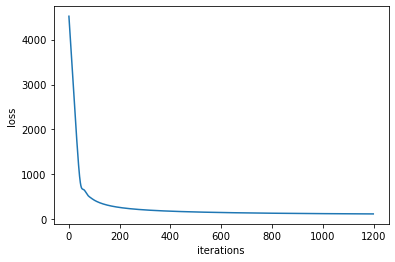

In [7]:
n_itr = 1200
carry,loss = jax.lax.scan(update_func, carry,xs = None,length= n_itr) 
plt.xlabel("iterations")
plt.ylabel("loss")
plt.plot(loss)

In [8]:
theta_map = carry['params']
theta_map

DeviceArray([19.651468, -9.940973, -4.563779], dtype=float32)

In [9]:
hessian = (jax.hessian(log_postfn)(theta_map))

In [10]:
hessian_inv = jnp.linalg.inv(hessian)

In [11]:
hessian_inv

DeviceArray([[ 2.1103745 , -1.0450168 , -0.50007206],
             [-1.045016  ,  0.71491045,  0.15020294],
             [-0.5000725 ,  0.15020332,  0.1850205 ]], dtype=float32)

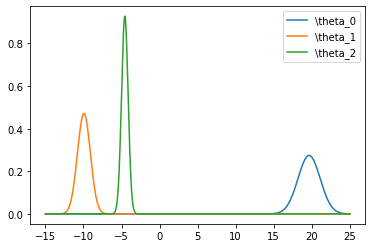

In [12]:
x = jnp.linspace(-15,25,10000)
for i in range(3):
    plt.plot(x, tfd.Normal(loc = theta_map[i], scale = jnp.sqrt(hessian_inv[i][i])).prob(x),label = r"\theta_"+str(i))
plt.legend()

In [13]:
scale_diag = jnp.sqrt(jnp.diagonal(hessian_inv))
distribution = tfd.MultivariateNormalDiag(loc = theta_map,scale_diag = scale_diag)

In [14]:
with open("./logistic_regression_laplace",'wb') as f:
    pickle.dump(distribution,f,protocol=1)